## Rising and falling flow rates 

Two images of a floodplain are generated: one representing rising water and one representing falling water. This was done by firstly generating a hydrograph, then choosing a threshold for flow (ie we are only interested in higher flows that represent flooding events). All satellite images corresponding to days when the flow level was higher than the threshold were retrieved from the WOfS database. Then it was attempted to separate the dates into 2 lists: one for days when the water was rising and one for days when the water was receeding. This was done by using a decision tree that checked if the day of the pass had a higher or lower reading than the gauge reading x days later. If the gauge reading x days after the pass was higher, that pass was put in the rising category. If it was lower, it was put in the receeding category. The user can check the accuracy of this method against the hydropgraph. Then an image of each dataset was generated to show the difference between rising water and receeding water.

## Imports
This code accesses python files located in the Scripts folder. Note that the Water Data Online data has been cached and this noetbook will access the cached code. If you want the most up to date data live from the BoM Water Data Online website, simply go into the Scripts folder and move the stations.pkl file out of there so the code can't find it. Then it will go look on the website instead.

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('Scripts')
import dea_bom

dc = datacube.Datacube(app='Inundation_mapping')


#retrieving data
stations_pkl = Path('Scripts/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('Scripts/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]

Loading from cache
4305 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

In [3]:
gauge_data, station = dea_bom.ui_select_station(stations)

Above is the hydrograph of the chosen gauge (in cubic meters per second). Please enter a minimum threshold for flow rate data you wish to analyse:

You have this many clear passes passes:171
Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.


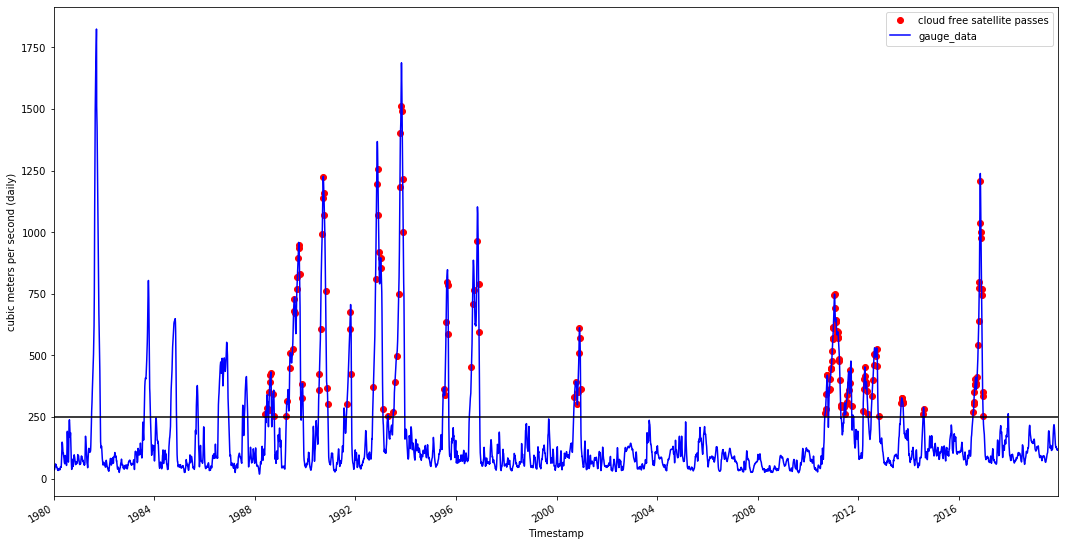

In [4]:
#set threshold for flow rate
yaxis_lower_parameter = 250


# The lat and lon takes the location of the gauge. You can change the lat 
# and lon to a different location if necessary, just comment out out this 
# lat, lon = pos line below and define your own.
lat, lon = station.pos

# lat =
# lon =

# The buffer is how many meters radius around the location you want to display.
buffer = 10000

lat, lon

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

#convert Pandas dataframe to xArray for merging with WOfS
gauge_data_xr = gauge_data.to_xarray() 

#this is the xArray merge function
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) 

#Now define the passes to load based on user input
specified_satellite_passes = merged_data.where((merged_data.Value > yaxis_lower_parameter), drop=True)
specified_satellite_passes = specified_satellite_passes.drop('Timestamp')

date_list = specified_satellite_passes.time.values


# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Cloud mask
cc = masking.make_mask(specified_passes.water, cloud=True)
npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice
ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)
clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.3)

#Now take the clear passes and make a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_specified_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called time
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')


#Plot the clear satellite passes over the hydrograph
ax = clear_merged_data.plot(marker = 'o', color='red', linestyle='None', figsize=(18,10))
plt.ylabel('cubic meters per second (daily)')
gauge_data.plot(ax=ax, color='blue')
plt.axhline(yaxis_lower_parameter, color='black') #putting a black line to show the chosen threshold
ax.legend(["cloud free satellite passes", "gauge_data"]);

#Check how many passes you are about to load. I recommend loading 100 to 400 passes.
print("You have this many clear passes passes:{}".format(clear_specified_passes.time.shape[0]))

print("Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.")

## Now separate the gauge data into 2 lists: rising and falling. Check the graph in the output to see how well the data was separated
### User selects what the multiplier and procedent should be
Splitting the data into rising and falling is quite hard. One option would be to use a numpy peak picking function and identify the passes on each side of the peak. This would require someone who can code numpy much better than I can. Instead I have used a method similar to the one MDBA has used previously for comparing rising to falling flows. This box will check whether the gauge-reading 21 days after the satellite pass was higher or lower than the day of the satellite pass. The multiplier represents by how much more the water should be lower or higher to be considered a significant change. I've just left it as 1 for simplicity. It puts the pass either into the rising or falling list accordingly. It runs a loop to do this for every single pass. The output will tell you how many passes you got in each list and show you how the passes were catagorised on a hydrogaph. 

number of rising passes(blue): 81
number of falling passes(red): 84
Here's a graph showing the passes that were characterised as rising or falling. Do you think the data was spilt accurately?
If not, try changing the days_ahead variable.


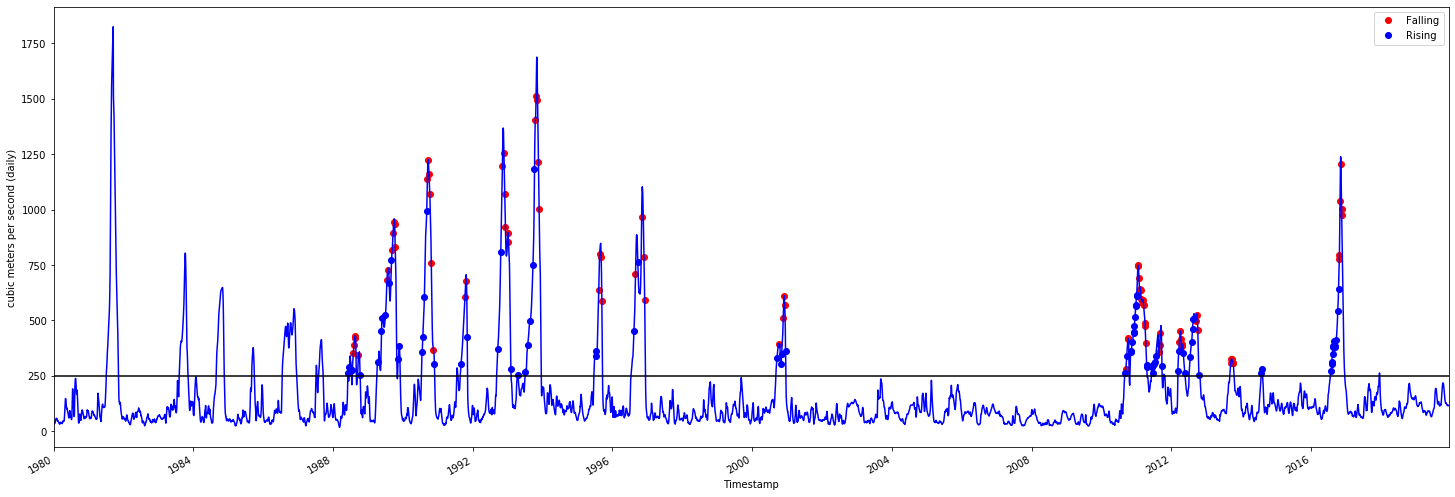

In [9]:
# SET PARAMETERS
#The multiplier specifies by how much more the flow rate has to rise by to be considered a significant rise
multiplier = 1

#The procedent is how many days in advance the algorithm checks for a rise or fall. 
#one day is not enough beacuse the data is too noisy to just do 1 day. 21 days is suggested. 
days_ahead = 35




# MAKE THE TWO LISTS FROM THE GAUGE DATA
#extract the flow rate values from the gauge data for the loop
gauge_data_values = gauge_data['Value']
gauge_data_values = gauge_data_values.where(gauge_data_values > yaxis_lower_parameter)
gauge_data_values = gauge_data_values.dropna()

i = 0
rising_list = []
falling_list = []
for value in gauge_data_values[:len(gauge_data_values)-days_ahead]:
    if value < gauge_data_values[i+days_ahead]*multiplier:
        rising_list.append(gauge_data_values.index[i])
    else:
        falling_list.append(gauge_data_values.index[i])
    i = i + 1



    
# CATAGORISE THE PASSES ACCORDING TO THE RISING AND FALLING LISTS
# Get rid of the timestamp in the pass dates
clear_merged_data.index = pd.DatetimeIndex(clear_merged_data.index.date)
clear_merged_data.index.name = 'date'
pass_list = clear_merged_data.index
pass_list = pass_list.tolist()
# Get rid of the timestamp in the rising and falling lists
ii = 0
rising_list_dates = []
for time in rising_list:
    rising_list_dates.append(rising_list[ii].replace(hour=0, minute=0, second=0, microsecond=0))
    ii = ii + 1
ii = 0
falling_list_dates = []
for time in falling_list:
    falling_list_dates.append(falling_list[ii].replace(hour=0, minute=0, second=0, microsecond=0))
    ii = ii + 1
#match the date lists up to the satellite passes
rising_passes1 = set(rising_list_dates) & set(pass_list)
rising_passes = list(rising_passes1)
falling_passes1 = set(falling_list_dates) & set(pass_list)
falling_passes = list(falling_passes1)




# CONVERT BACK TO PANDAS DATAFRAME SO YOU CAN MAKE THE GRAPH:
# get rid of the timestamp on the date index so it can matched to the rising and falling dataframes later
clear_merged_data.index = pd.DatetimeIndex(clear_merged_data.index.date)
clear_merged_data.index.name = 'date'

# Change the list of rising passes into a pandas dataframe with the date as the index
rising_passes_df = pd.DataFrame(rising_passes)
rising_passes_df.columns = ['date']
rising_passes_df['date'] = pd.to_datetime(rising_passes_df['date'])
rising_passes_df = rising_passes_df.set_index(['date'])
# Extract the values column from the merged data
rising_passes_df = rising_passes_df.join(clear_merged_data)

# And do the same for falling
falling_passes_df = pd.DataFrame(falling_passes)
falling_passes_df.columns = ['date']
falling_passes_df['date'] = pd.to_datetime(falling_passes_df['date'])
falling_passes_df = falling_passes_df.set_index(['date'])
# Extract the values column from the merged data
falling_passes_df = falling_passes_df.join(clear_merged_data)

# Plot the rising and falling passes over the hydrograph
ax = falling_passes_df.plot(marker = 'o', color='red', linestyle='None', figsize=(25,9))
plt.ylabel('cubic meters per second (daily)')
rising_passes_df.plot(ax=ax, marker = 'o', color = 'blue', linestyle='None')
gauge_data.plot(ax=ax, color='blue')
plt.axhline(yaxis_lower_parameter, color='black') #putting a black line to show the chosen threshold
ax.legend(["Falling", "Rising"]);

print("number of rising passes(blue): {}".format(len(rising_passes)))
print("number of falling passes(red): {}".format(len(falling_passes)))
print("Here's a graph showing the passes that were characterised as rising or falling. Do you think the data was spilt accurately?")
print("If not, try changing the days_ahead variable.")

## Generate an image of the rising passes and a second one of the falling passes

Now we'll make an image that represents the frequency of water for each list. The rising image will take all the satellite images from the rising list and layer them to create a summary image of what the river looked like on days that we specified that the water level was rising, and same same for the falling list. 

number of rising passes: 81
number of falling passes: 84


Text(0.5, 1.0, 'falling')

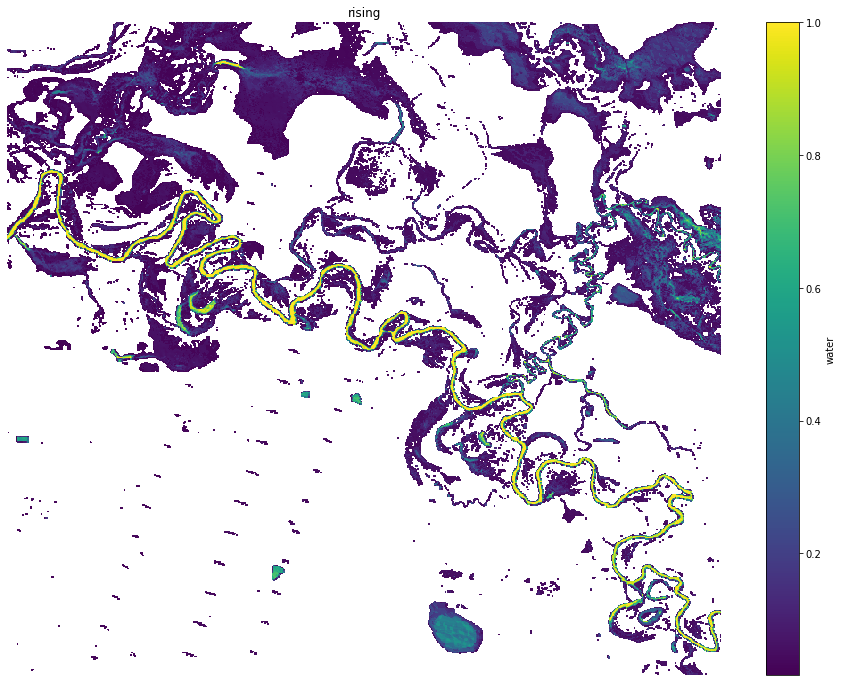

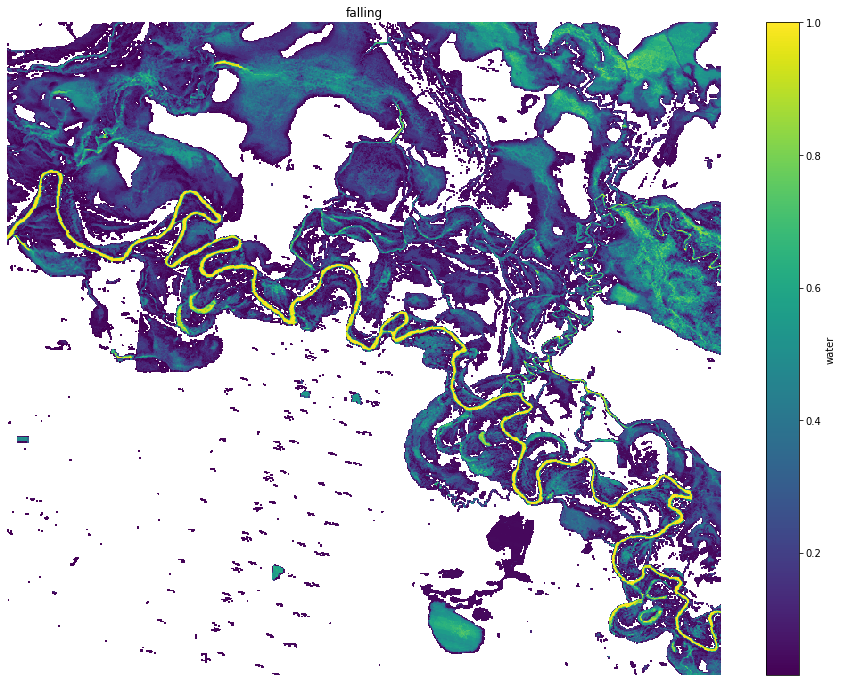

In [10]:
rising_picture = clear_specified_passes.reindex(time=rising_passes,
                                                        method='nearest',tolerance=np.timedelta64(1,'D'))
falling_picture = clear_specified_passes.reindex(time=falling_passes,
                                                        method='nearest',tolerance=np.timedelta64(1,'D'))

print("number of rising passes: {}".format(len(rising_passes)))
print("number of falling passes: {}".format(len(falling_passes)))

wet_rising = (rising_picture == 128).sum(dim='time')
dry_rising = (rising_picture == 0).sum(dim='time')
clear_rising = wet_rising + dry_rising
frequency_rising = wet_rising / clear_rising
frequency_rising = frequency_rising.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_rising = frequency_rising.where(frequency_rising!=0) #This is to tell it to make areas that were dry 100% of the time white

frequency_rising.plot(figsize = (16, 12))
plt.axis('off')
plt.title('rising')

wet_falling = (falling_picture == 128).sum(dim='time')
dry_falling = (falling_picture == 0).sum(dim='time')
clear_falling = wet_falling + dry_falling
frequency_falling = wet_falling / clear_falling
frequency_falling = frequency_falling.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_falling = frequency_falling.where(frequency_falling!=0) #This is to tell it to make areas that were dry 100% of the time white

frequency_falling.plot(figsize = (16, 12))
plt.axis('off')
plt.title('falling')

# Let's make a delta image
#delta = frequency_rising - frequency_falling

# Plotting the image
#delta.plot(figsize = (16, 12), vmin = -0.2, vmax = 0.2, cmap = 'RdYlBu_r')
#plt.axis('off')
#plt.title("After minus before: Blue means there was more water there in the falling phase")
#plt.show()